<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-08-11 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.7.0


In [2]:
%matplotlib inline
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

import comptools as comp
import comptools.analysis.plotting as plotting
    
color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
config = 'IC86.2012'
comp_list = ['light', 'heavy']
pipeline_str = 'BDT'
feature_list, feature_labels = comp.get_training_features()
print('Training features = {}'.format(feature_list))

Training features = ['lap_cos_zenith', 'log_s125', 'log_dEdX']


In [4]:
df_sim_train, df_sim_test = comp.load_sim(config=config)
pipeline = comp.get_pipeline(pipeline_str)

Starting out with 108522 sim events
sim quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:  0.793  0.793
       passed_InIceQualityCuts:  0.795   0.76
                 num_hits_1_60:  0.997  0.759
             reco_energy_range:  0.874  0.662




In [5]:
X_train, y_train = comp.dataframe_to_X_y(df_sim_train, feature_list)
X_test, y_test = comp.dataframe_to_X_y(df_sim_test, feature_list)

In [6]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)

pipeline = pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print('Training accuracy = {:.2%}'.format(train_acc))

test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print('Testing accuracy = {:.2%}'.format(test_acc))

print('=' * 30)

GradientBoostingClassifier
Training accuracy = 75.54%
Testing accuracy = 75.14%


In [7]:
light_mask = df_sim_train['MC_comp_class'] == 'light'
heavy_mask = df_sim_train['MC_comp_class'] == 'heavy'
null_mask = ~df_sim_train['refit_beta'].isnull()
energy_mask = (df_sim_train['log_s125'] > 1.9) & (df_sim_train['log_s125'] <= 2.1)
zenith_mask = (df_sim_train['lap_cos_zenith'] > 0.9) & (df_sim_train['lap_cos_zenith'] <= 1.0)
# radius_mask = (df_sim_train['avg_inice_radius_1_60'] > 120) & (df_sim_train['avg_inice_radius_1_60'] <= 130)

In [8]:
null_mask.sum()/len(null_mask)

0.99268404206675809

In [12]:
# feature_dict =  {'log_s125': 2.0, 'lap_cos_zenith': 0.95}
feature_dict =  {'lap_cos_zenith': 0.95}

In [ ]:
g = sns.JointGrid(x=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  y=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(100, 160), space=0)


plotting.plot_decision_slice('log_dEdX', 'avg_inice_radius_1_60', sim_train_df[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.02, yres=0.02, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(100, 160, 50)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_train_df['log_dEdX'][heavy_mask & energy_mask]
g.y = sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

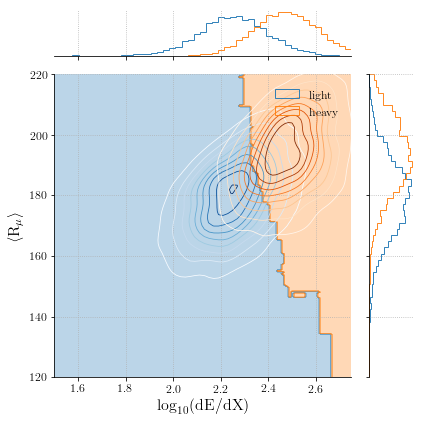

In [24]:
g = sns.JointGrid(x=sim_df_train['log_dEdX'][light_mask & energy_mask],
                  y=sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(120, 220), space=0)


plotting.plot_decision_slice('log_dEdX', 'invqweighted_inice_radius_1_60', sim_df_train[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.01, yres=0.5, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_df_train['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(120, 220, 50)
_ = g.ax_marg_x.hist(sim_df_train['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask]
g.y = sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

# g.ax_joint.scatter(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
#                    color='C0', alpha=0.02)
# g.ax_joint.scatter(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
#                    color='C1', alpha=0.02)

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
# g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# # g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
# g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

In [8]:
zenith_min = 0.95
zenith_max = 1.0
zenith_mask = (df_sim_train['lap_cos_zenith'] >= zenith_min) & (df_sim_train['lap_cos_zenith'] <= zenith_max)
feature_dict =  {'lap_cos_zenith': np.mean([zenith_min, zenith_max])}
feature_mask = zenith_mask

In [9]:
feature_dict

{'lap_cos_zenith': 0.97499999999999998}

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


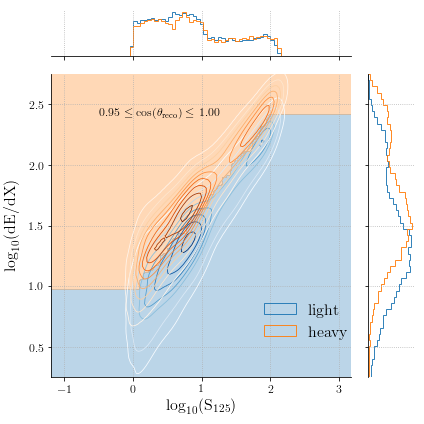

In [10]:
g = sns.JointGrid(y=df_sim_train['log_dEdX'][light_mask],
                  x=df_sim_train['log_s125'][light_mask],
                  ylim=(0.25, 2.75), xlim=(-0.25, 2.25), space=0)

# Plot decision region using mlxtend
g.ax_joint = plot_decision_regions(X_train, y_train, clf=pipeline,
                                   feature_index=[1, 2], filler_feature_values={0: np.mean([zenith_min, zenith_max])},
                                   res=0.02, legend=0, colors='C0,C1', hide_spines=False, 
                                   ax=g.ax_joint)

# Contours of light training data
light_contour = sns.kdeplot(df_sim_train['log_s125'][light_mask & feature_mask],
                            df_sim_train['log_dEdX'][light_mask & feature_mask],
                            cmap='Blues', label='light', ax=g.ax_joint)
# Histogram of light training data features
dE_dX_bins = np.linspace(0.25, 2.75, 50)
s125_bins = np.linspace(-0.25, 2.25, 50)
_ = g.ax_marg_x.hist(df_sim_train['log_s125'][light_mask & feature_mask], histtype='step',
                     color='C0', alpha=.9, bins=s125_bins, label='light')
_ = g.ax_marg_y.hist(df_sim_train['log_dEdX'][light_mask & feature_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, orientation="horizontal")

# Contours of heavy training data
g.y = df_sim_train['log_dEdX'][heavy_mask & feature_mask]
g.x = df_sim_train['log_s125'][heavy_mask & feature_mask]
heavy_contour = sns.kdeplot(df_sim_train['log_s125'][heavy_mask & feature_mask],
                            df_sim_train['log_dEdX'][heavy_mask & feature_mask],
                            cmap='Oranges', label='heavy', ax=g.ax_joint)
# Histogram of heavy training data features
_ = g.ax_marg_x.hist(df_sim_train['log_s125'][heavy_mask & feature_mask], histtype='step',
                     color='C1', alpha=.9, bins=s125_bins, label='heavy')
_ = g.ax_marg_y.hist(df_sim_train['log_dEdX'][heavy_mask & feature_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_y.grid(axis='y')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -5.0),
                   frameon=False, ncol=1)

g.ax_joint.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
g.ax_joint.text(-0.5, 2.4, 
                '{:0.2f} '.format(zenith_min) + '$\mathrm{ \leq \cos(\\theta_{reco}) \leq }$' + ' {:0.2f}'.format(zenith_max), 
                fontsize=12)

outfile = os.path.join(comp.paths.figures_dir, 
                       'model_evaluation/dEdX-vs-s125-contours_zenith-{:0.2f}-{:0.2f}.png'.format(zenith_min, 
                                                                                                  zenith_max))
g.savefig(outfile)

In [25]:
sim_train_df.log_s125.plot(kind='hist', bins=50)
plt.show()

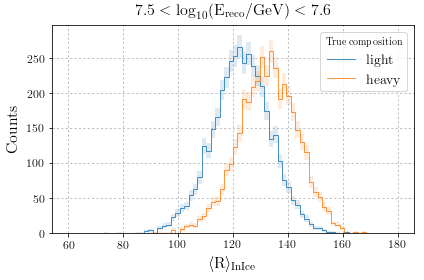

In [18]:
radius_bins = np.linspace(60, 180, 75)

fig, ax = plt.subplots()

# df_sim['log_dEdX'][light_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='light', ax=ax)
# df_sim['log_dEdX'][heavy_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='heavy', ax=ax)

light_counts = np.histogram(df_sim['avg_inice_radius'][light_mask & energy_mask], radius_bins)[0]
heavy_counts = np.histogram(df_sim['avg_inice_radius'][heavy_mask & energy_mask], radius_bins)[0]

plotting.plot_steps(radius_bins, light_counts, yerr=np.sqrt(light_counts), ax=ax, color='C0', label='light')
plotting.plot_steps(radius_bins, heavy_counts, yerr=np.sqrt(heavy_counts), ax=ax, color='C1', label='heavy')

# ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Counts')
ax.set_xlabel('$\mathrm{\langle R \\rangle _{InIce}}$')
ax.set_title('$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) < 7.6 }$')
# ax.set_xlim([70, 170])
ax.set_ylim(0)
ax.grid()
ax.legend(title='True composition')
plt.savefig('/home/jbourbeau/public_html/figures/avg-radius-dist-example.png')
plt.show()

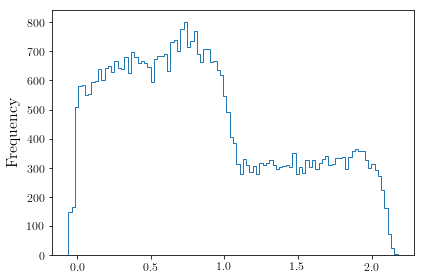

In [19]:
df_sim_train[feature_mask].log_s125.plot(kind='hist', bins=100, histtype='step');

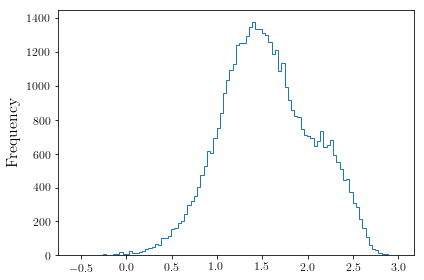

In [20]:
df_sim_train[feature_mask].log_dEdX.plot(kind='hist', bins=100, histtype='step');